In [1]:
# Import the required packages

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
#import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
import itertools


In [2]:
#Set up plotting themes
sns.set_context('poster')
sns.set_style('darkgrid')

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [3]:
def clean_data(filename):
    # print(filename)
    # Handle errors. If there is an error, go to 'except' and return nothing.
    try:
        data = pd.read_csv('data/' + filename)

        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        data = data.dropna(subset=['blocks.thisRepN']).reset_index(drop=True)

        #If data file is incomplete, raise an error. 
        if sum(data['node idx'].notna()) < 1400:
            raise TypeError('Incomplete Data')


        #Rt is average rt of all keys pressed
        data['rt'] = [np.mean(ast.literal_eval(data['key_resp.rt'][i])) if data['accuracy'][i] else np.NaN for i in range(len(data))]
        
        #Transition type is cross cluster if goes from boundary to boundary
        data['transition_type'] = ['cross cluster' if (data['node type'] == 'boundary')[i] & (data['node type'].shift() == 'boundary')[i] else 'within cluster' for i in range(len(data))]

        #Label conditions based on participant number as was designed in the experiment
        if data['participant'][0]%3 == 0:
            data['condition'] = 'random'
        elif data['participant'][0]%3 == 1:
            data['condition'] = 'music random'
        else:
            data['condition'] = 'structured'

        data['trial'] = np.arange(len(data))
        
        
    except:
        return None

    #Count the number of keys to be pressed for each stimuli
    data['num_keypress'] = [len(ast.literal_eval(data['stim'][i])) for i in range(len(data))]
    
    #Return the dataframe with relevant columns
    return data[['participant', 'trial', 'blocks.thisRepN', 'accuracy', 'condition', 'node type', 'transition_type', 'rt', 'stim', 'num_keypress']]


# Read the data files

In [19]:
#reads in all the NAMES of the data files from the 'data' folder. 
data_files = []
for f in os.listdir('data/'):
    if (f.startswith('240') & f.endswith('csv')):
        data_files.append(f)

# Sanity Check 1 
Print out the data_files variable and test if correct files are being loaded

In [20]:
data_files

['240018_eb_music_2024-03-27_13h18.21.516.csv',
 '240025_eb_music_2024-03-28_13h19.35.843.csv',
 '240019_eb_music_2024-03-27_15h41.50.111.csv',
 '240015_eb_music_2024-03-27_11h23.41.504.csv',
 '240021_eb_music_2024-03-28_12h37.06.193.csv',
 '240023_eb_music_2024-03-28_13h42.52.188.csv',
 '240028_eb_music_2024-04-01_14h14.11.027.csv',
 '240010_eb_music_2010-09-21_02h04.06.427.csv',
 '240017_eb_music_2024-03-27_12h53.21.987.csv',
 '240000_eb_music_2024-03-13_13h32.51.559.csv',
 '240001_eb_music_2024-03-13_13h28.21.687.csv',
 '240027_eb_music_2024-04-01_12h34.31.005.csv',
 '240005_eb_music_2010-09-20_02h29.21.924.csv',
 '240006_eb_music_2010-09-21_01h01.38.600.csv',
 '240024_eb_music_2024-03-28_13h20.30.963.csv',
 '240009_eb_music_2024-03-15_12h47.17.042.csv',
 '240008_eb_music_2024-03-15_12h02.14.101.csv',
 '240013_eb_music_2024-03-25_12h49.02.447.csv',
 '240026_eb_music_2024-04-01_12h14.44.476.csv',
 '240004_eb_music_2024-03-14_12h59.27.819.csv',
 '240003_eb_music_2024-03-14_12h29.04.60

# Cleaning the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [21]:
df_clean = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)
# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'blocks.thisRepN', 'condition', 'node type', 'transition_type']).median(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

# Sanity Check 2
Print out the dataframe df_clearn_rt_outlier to see if it looks as expected. 

Take a note of the relevant columns

In [22]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,condition,node type,transition_type,rt,stim,num_keypress
0,240018.0,0,0.0,1.0,random,non boundary,within cluster,0.643316,"('space',)",1
1,240018.0,1,0.0,1.0,random,boundary,within cluster,1.177603,"('j',)",1
2,240018.0,2,0.0,1.0,random,boundary,cross cluster,0.932779,"('h', 'l')",2
3,240018.0,3,0.0,1.0,random,non boundary,within cluster,0.547360,"('l',)",1
4,240018.0,4,0.0,1.0,random,non boundary,within cluster,0.405620,"('h',)",1
...,...,...,...,...,...,...,...,...,...,...
30794,240012.0,1394,6.0,1.0,random,non boundary,within cluster,1.078448,"('l',)",1
30795,240012.0,1395,6.0,1.0,random,boundary,within cluster,1.215838,"('j', 'space')",2
30797,240012.0,1397,6.0,1.0,random,boundary,within cluster,0.659638,"('k',)",1
30798,240012.0,1398,6.0,1.0,random,boundary,cross cluster,1.164311,"('j', 'space')",2


In [27]:
df_clean_rt_outlier['node_transition_type']=df_clean_rt_outlier['node type']+'_'+df_clean_rt_outlier['transition_type']

In [28]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,condition,node type,transition_type,rt,stim,num_keypress,node_transition_type
0,240018.0,0,0.0,1.0,random,non boundary,within cluster,0.643316,"('space',)",1,non boundary_within cluster
1,240018.0,1,0.0,1.0,random,boundary,within cluster,1.177603,"('j',)",1,boundary_within cluster
2,240018.0,2,0.0,1.0,random,boundary,cross cluster,0.932779,"('h', 'l')",2,boundary_cross cluster
3,240018.0,3,0.0,1.0,random,non boundary,within cluster,0.547360,"('l',)",1,non boundary_within cluster
4,240018.0,4,0.0,1.0,random,non boundary,within cluster,0.405620,"('h',)",1,non boundary_within cluster
...,...,...,...,...,...,...,...,...,...,...,...
30794,240012.0,1394,6.0,1.0,random,non boundary,within cluster,1.078448,"('l',)",1,non boundary_within cluster
30795,240012.0,1395,6.0,1.0,random,boundary,within cluster,1.215838,"('j', 'space')",2,boundary_within cluster
30797,240012.0,1397,6.0,1.0,random,boundary,within cluster,0.659638,"('k',)",1,boundary_within cluster
30798,240012.0,1398,6.0,1.0,random,boundary,cross cluster,1.164311,"('j', 'space')",2,boundary_cross cluster


# Plot RTs
The dataframe that is created above (df_clearn_rt_outlier) removes outliers where people may have responded too quickly or too slowly. This is the dataframe we want to work with. Let's start by plotting first. 

Plot a graph using python's seaborn package such that: 
1. The Y axis is the average response time
2. The X axis is the block number
3. The graph has three 'column' panels corresponding to the three conditions.


(Hint: Use the seaborn catplot function)

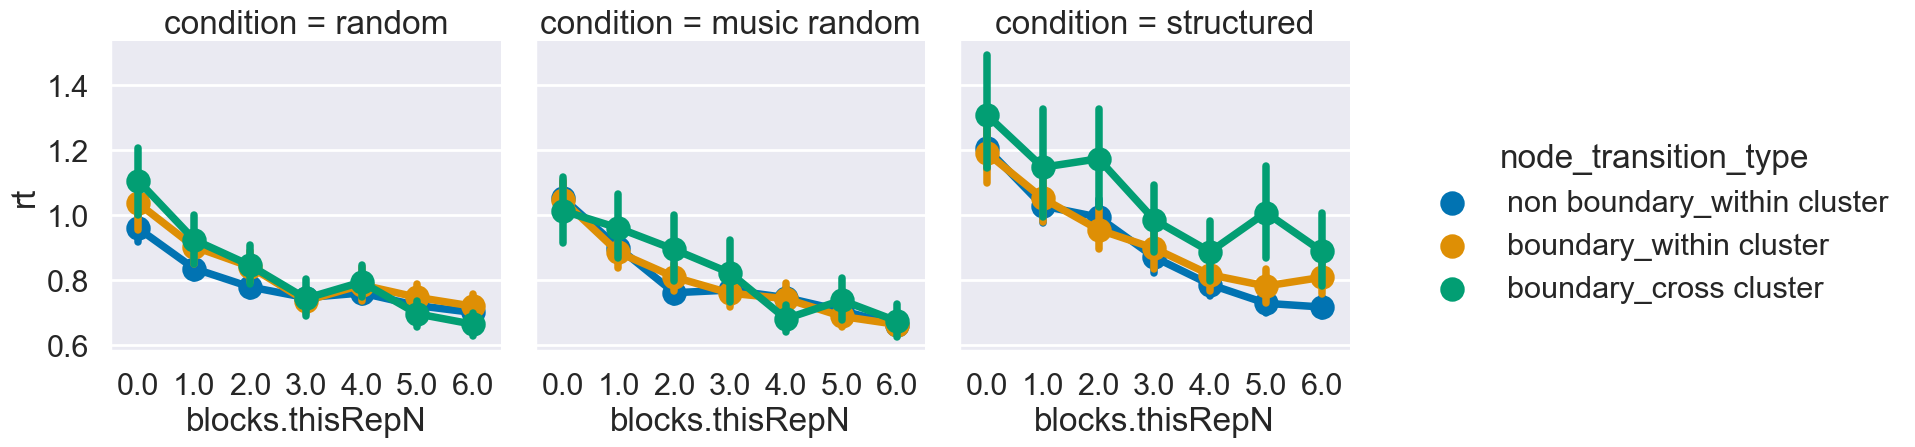

In [35]:
sns.catplot(data=df_clean_rt_outlier, y='rt', x='blocks.thisRepN', hue='node_transition_type', row=None, col='condition', 
            kind='point', margin_titles=True, estimator='mean', seed=0,
           palette=sns.color_palette("colorblind"))


# Plot Accuracies
That dataframe also has a column called 'accuracy'. Use that colum to plot a graph using python's seaborn package such that: 
1. The Y axis is the average accuracy
2. The X axis is the block number
3. The graph has three 'column' panels corresponding to the three conditions. 

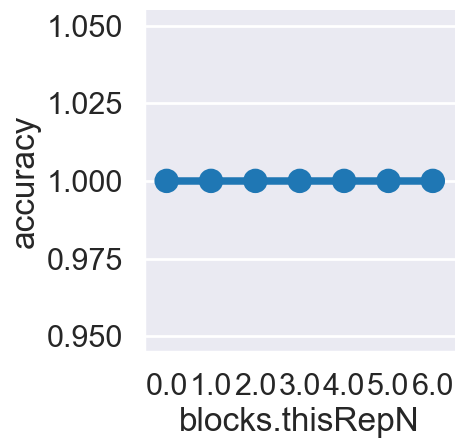

In [10]:
sns.catplot(data=df_clean_rt_outlier, y='accuracy', x='blocks.thisRepN', hue=None, row=None, col=None, kind='point', estimator='mean', seed=0, order=None, hue_order=None, row_order=None, col_order=None, col_wrap=None)





In [4]:
import seaborn as sns 
  
music = sns.load_dataset("data_files") 
g = sns.catplot(x="blocks.thisRepN", y=mean("accuracy"), 
                hue="condition", 
                data=music)

ValueError: 'data_files' is not one of the example datasets.